# Assignment Week 9: House Price Regression using CNN

## Student ID: 250970798

In this lab we will show how to work with mixed data, also called multimodal learning, using deep learning. Mixed data is anything that is not just one type of data, such as mixing traditional structured data with images, or with audio, video, etc. The possibilities are endless!

We will compare a model using the structured data we have available, a model using only the images available and finally a model combining both inputs. This week's work may be too much for your personal computer to handle, so just work on a reduced sample if you see the process taking too much time. You can also just run the assignment in the cloud using either [Google Colab](https://colab.research.google.com/) or [Kaggle Kernels](https://www.kaggle.com/kernels), activiting a GPU environment (In Colab: Navigate to Edit→Notebook Settings and select GPU from the Hardware Accelerator drop-down. For Kaggle Kernels, [follow these instructions](https://www.kaggle.com/dansbecker/running-kaggle-kernels-with-a-gpu)).


## Packages

You will need to install the `pytorch` and `torchvision` packages.
To do so, I suggest starting a terminal by choosing File -> New -> Terminal from the JupyterLab menu, and running
`pip install torch torchvision`

In [1]:
from IPython.display import clear_output
from matplotlib import pyplot as plt
import collections
import numpy as np
import pandas as pd
from IPython.display import Image
import torch
import torchvision
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from torch.utils.data import Dataset
from sklearn.preprocessing import StandardScaler
from typing import Dict, Any
import os

%matplotlib inline

def live_plot(loss, train_acc, valid_acc=None, figsize=(7,5), title=''):
    clear_output(wait=True)
    fig, ax1 = plt.subplots(figsize=figsize)
    ax1.plot(loss, label='Training Loss', color='red')
    ax1.legend(loc='lower left')
    ax1.set_ylabel('Mean Square Error Loss')
    ax2 = ax1.twinx()
    ax2.plot(train_acc, label='Training MSE', color='green')
    if valid_acc is not None:
        ax2.plot(valid_acc, label='Validation MSE', color='blue')
    ax2.legend(loc='lower right')
    ax2.set_ylabel('MSE')
    ax2.set_xlabel('Epoch')
    plt.title(title)
    plt.show()

## Data Import and Preprocessing

The objective of the problem is to create a model that predicts house prices using the property's basic information (Bedrooms, bathrooms, area in sqft, zipcode) and a collage of four images in the house. Download the zip file from OWL and decompress it in the folder you are working on. Alternatively, you can run these lines of code if you are using Colab

In [2]:
# Download and unzip the data. Uncomment if you are using a cloud environment.
!gdown https://drive.google.com/uc?id=1XZGDY0XVHNDawfMymX7d1BRO5a17KIN5
!!unzip HousesDatasetClean.zip

Downloading...
From: https://drive.google.com/uc?id=1XZGDY0XVHNDawfMymX7d1BRO5a17KIN5
To: /Users/yuchenzhou/Downloads/HousesDatasetClean.zip
232MB [00:39, 5.86MB/s] 


['Archive:  HousesDatasetClean.zip',
 'replace HousesDatasetClean/1/0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename:  NULL',
 '(EOF or read error, treating as "[N]one" ...)']

The data has the following structured attributes, in the file ``HousesInfo.csv``:

- Number of bedrooms and bathrooms.
- Surface area of the house.
- Zipcode the house is located in (Categorical. We'll ignore it in this assignment.)
- **House price (target variable)**.

Run this code to load the data.

In [3]:
HouseData = pd.read_csv('HousesDatasetClean/HousesInfo.csv')
HouseData.drop(columns='zipcode', inplace=True)
HouseData.describe()

,bedrooms,bathrooms,area,price
count,535.000000,535.000000,535.000000,5.350000e+02
mean,3.377570,2.664953,2364.904673,5.893628e+05
std,1.160952,0.995077,1224.556982,5.090261e+05
min,1.000000,1.000000,701.000000,2.200000e+04
25%,3.000000,2.000000,1440.000000,2.492000e+05
50%,3.000000,2.500000,2078.000000,5.290000e+05
75%,4.000000,3.000000,3067.500000,7.285000e+05
max,10.000000,7.000000,9583.000000,5.858000e+06


And each element comes with a collage of four pictures representing different parts of the house. Here is an example. 

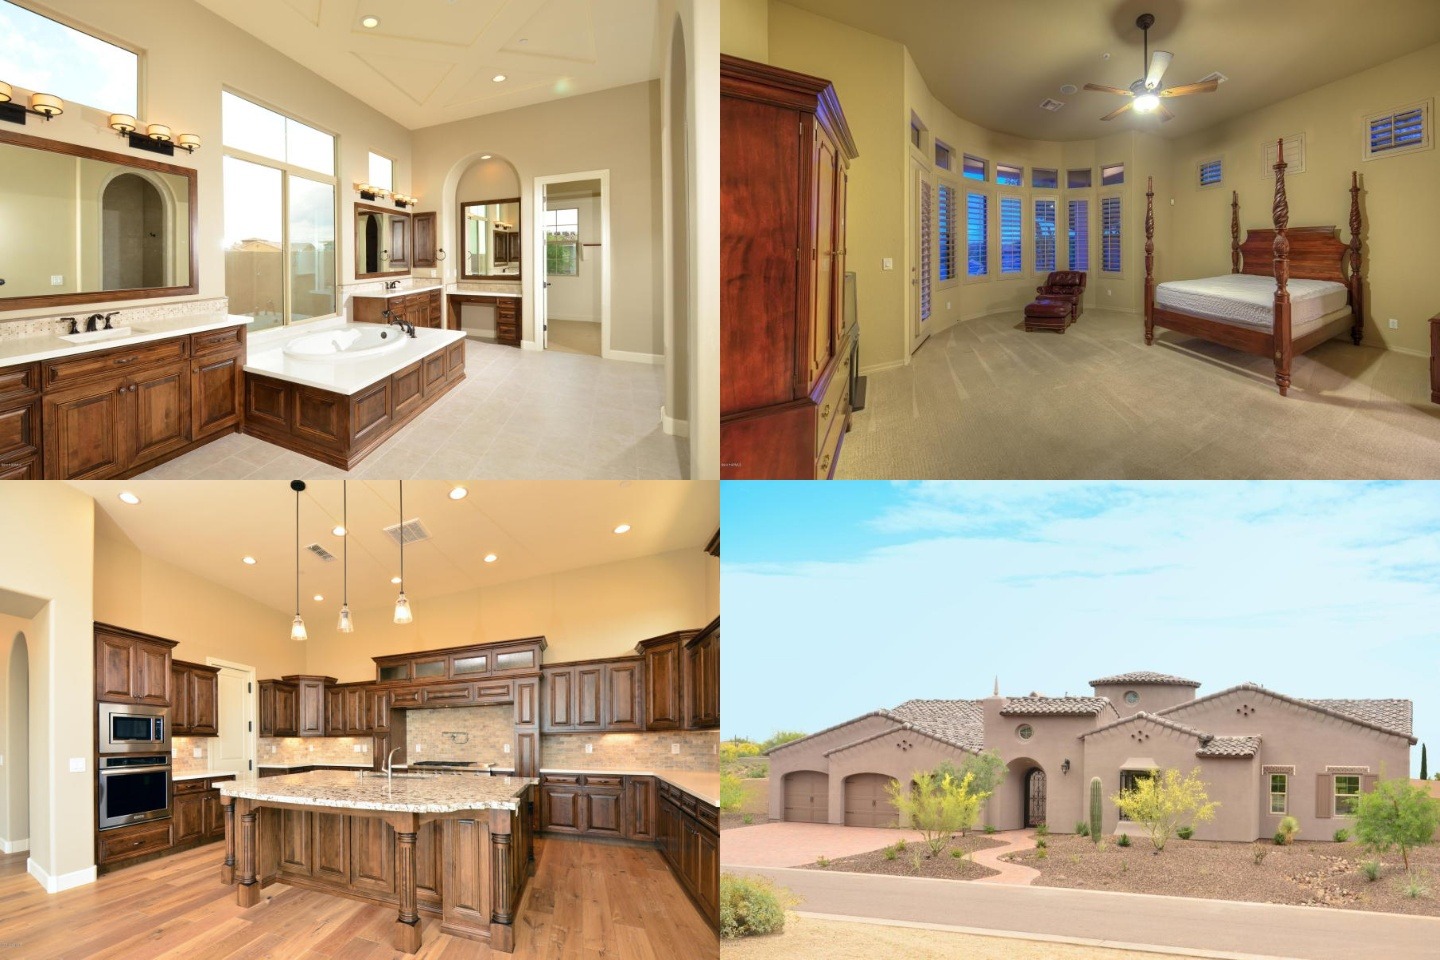

In [4]:
Image(filename='HousesDatasetClean/1/4.jpg')

**For every element in the HouseData dataset, there is a corresponding image in the HouseDatasetClean folder, following the same index. So, for index 0 of the dataset, there is a picture 0.jpg in the HouseDatasetClean folder.**

## Task 1: Non-Linear Structured Model in PyTorch (30 pts)

For the first task, build a model in PyTorch that takes bedrooms, bathrooms, and the area variables and predicts the price of the house. For this we first need a dataset iterator, created below. To read more about data iterators, [read this explanation](https://pytorch.org/docs/stable/data.html).

In [5]:
# Data iterators. Run first.
class StructuredDataset(Dataset):
    def __init__(self, x, y):
        super(StructuredDataset, self).__init__()
        assert x.shape[0] == y.shape[0]
        if torch.cuda.is_available():
            device = 'cuda'
        else:
            device = 'cpu'
        self.x_data = torch.as_tensor(x, device=device, dtype=torch.float)
        self.y_data = torch.as_tensor(y, device=device, dtype=torch.float)


    def __len__(self):
        return self.y_data.shape[0]

    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]


# Load data into 'flattened' NumPy arrays [5 pts]
train, test = train_test_split(HouseData, 
                               test_size = 0.3,
                               random_state = 20201207)


# Normalize the data
normalizer = StandardScaler()
train = normalizer.fit_transform(train)
test = normalizer.transform(test)

# Define the dataset
traindata = StructuredDataset(train[:, :-1], train[:, -1])

# Create iterator. Pass this to the enumerate function.
batch_size = 32
trainloader = torch.utils.data.DataLoader(traindata, batch_size=batch_size, shuffle=True)

This has created a `trainloader` object that shuffles the dataset and pulls examples. We can use this to train our neural network. Now we can start creating the model, you'll take it from here. First:

a. Create a model in PyTorch that predicts the price of the house using the other varibles. Use the following architecture:

- [ReLU activation functions](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html) in all layers, including the output layer.
- SGD optimizer with a learning rate of 0.01
- Mean square error loss function ([MSELoss](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html)).
- Two hidden layers with 1024 neurons each
- One output layer with an adequate number of neurons in the output layer for a regression problem.

You should see something like this after creating your model.

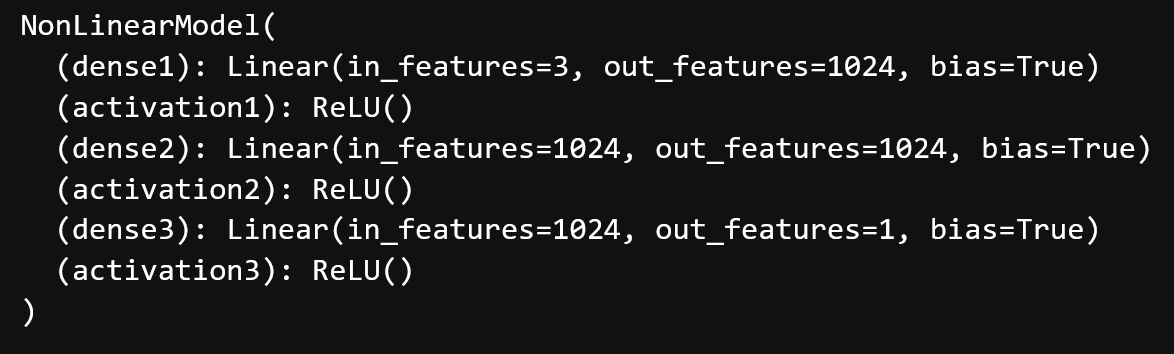

In [6]:
# Define the architecture [20 pts]
class NonLinearModel(torch.nn.Module):
    
    def __init__(self):
        
        super().__init__()
         
        self.dense1 = torch.nn.Linear(in_features=3, out_features=1024,bias=True)
        self.activation1 = torch.nn.ReLU()
        self.dense2 = torch.nn.Linear(in_features=1024, out_features=1024,bias=True)
        self.activation2 = torch.nn.ReLU()
        self.dense3=torch.nn.Linear(in_features=1024,out_features=1,bias=True)
        self.activation3=torch.nn.ReLU()
        
    def forward(self, X):
        X = self.dense1(X)  
        X = self.activation1(X)
        X = self.dense2(X)
        X = self.activation2(X)
        X = self.dense3(X)
        x = self.activation3(X)
        return X

In [35]:
#Initiate the model. Result should look like the example above.
max_iter=200
model = NonLinearModel()
optimizer=torch.optim.SGD(model.parameters(), lr=0.01)
criterion = torch.nn.MSELoss()


b. Train the model until you obtain convergence. Plot the error over the train set as you train. **Written answer: Can the model capture the price variations with the data you have? Why? Why not?**

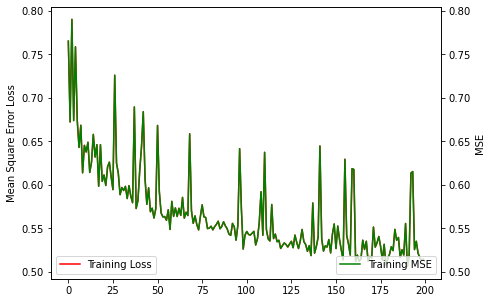

In [36]:
# Train! [10 pts]

batch_limit=12
batch_size = 32
loss_list=[]

for i in range(max_iter):
    epoch_loss = 0
    for index,(data, label) in enumerate(trainloader):
        optimizer.zero_grad()
        y_pred = model(data)
        loss = criterion(input=y_pred, target=label.reshape(-1,1))
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    with torch.no_grad():
        loss_list.append(epoch_loss/batch_limit)
        live_plot(np.array(loss_list),np.array(loss_list))



mean squared error for test set is 0.48602334302075784


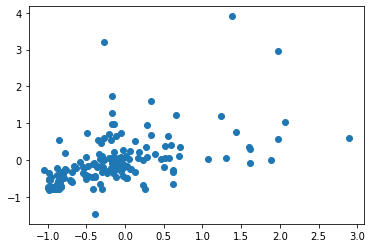

In [43]:
# testing set
with torch.no_grad():

    y_pred=model.forward(torch.Tensor(test[:, :-1]))
    print("mean squared error for test set is",mean_squared_error(y_pred.detach().numpy(),test[:,-1]))

plt.scatter(test[:,-1],y_pred.detach().numpy())

**Written answer here.**
Yes, it can. The mean squared error for the test set is small, so the model can accurately predict house price. Furthermore, the scatterplot  plots the predicted value against real value. You can see that most of the values can be predicted correctly. However, there are some data points that are predicted incorrectly.

## Task 2: Tweaking the model. [45 pts]

Now, repeat Task 1, but modify the following parameters:

a. Number of hidden layers. Try using just one and the two you used above.

b. Neurons in the hidden layer. Try 512, 1024 and 2048 (keep the same number in both layers when using 2).

c. Learning rate. Reduce it to $10^{-4}$ and increase it to $10^{-1}$.

**Written answer: Can you beat the original model in test set MSE? What combination of parameters leads to a better solution? Why do you think this is? What parameters are more important?**

In [29]:
# You'll need several cells of code. Add as many as you need!

#--------------model 1: two layer, 1024, 1e-4---------------------
model1 = NonLinearModel()
optimizer=torch.optim.SGD(model1.parameters(), lr=1e-4)
batch_limit=12
batch_size = 32
loss_list=[]

for i in range(max_iter):
    for index,(data, label) in enumerate(trainloader):
        optimizer.zero_grad()
        y_pred = model1(data)
        loss = criterion(input=y_pred, target=label.reshape(-1,1))
        loss.backward()
        optimizer.step()

with torch.no_grad():
    y_pred=model1.forward(torch.Tensor(test[:, :-1]))
    print("model 1 :mean squared error for test set is",mean_squared_error(y_pred.detach().numpy(),test[:,-1]))


model 1 :mean squared error for test set is 0.3877042142436868


In [11]:
#--------------model 2: two layer, 1024, 1e-1---------------------
model2 = NonLinearModel()
optimizer=torch.optim.SGD(model2.parameters(), lr=1e-1)
batch_limit=12
batch_size = 32
loss_list=[]

for i in range(max_iter):
    for index,(data, label) in enumerate(trainloader):
        optimizer.zero_grad()
        y_pred = model2(data)
        loss = criterion(input=y_pred, target=label.reshape(-1,1))
        loss.backward()
        optimizer.step()

with torch.no_grad():
    y_pred=model2.forward(torch.Tensor(test[:, :-1]))
    print("model 2 :mean squared error for test set is",mean_squared_error(y_pred.detach().numpy(),test[:,-1]))

model 2 :mean squared error for test set is 0.565743390905501


In [12]:
class SmallNonLinearModel(torch.nn.Module):
    
    def __init__(self):
        
        super().__init__()
         
        self.dense1 = torch.nn.Linear(in_features=3, out_features=512,bias=True)
        self.activation1 = torch.nn.ReLU()
        self.dense2 = torch.nn.Linear(in_features=512, out_features=512,bias=True)
        self.activation2 = torch.nn.ReLU()
        self.dense3=torch.nn.Linear(in_features=512,out_features=1,bias=True)
        self.activation3=torch.nn.ReLU()
        
    def forward(self, X):
        X = self.dense1(X)  
        X = self.activation1(X)
        X = self.dense2(X)
        X = self.activation2(X)
        X = self.dense3(X)
        x = self.activation3(X)
        return X






#--------------model 3: two layer, 512, 1e-4---------------------

model3 = SmallNonLinearModel()
optimizer=torch.optim.SGD(model3.parameters(), lr=1e-4)
batch_limit=12
batch_size = 32
loss_list=[]

for i in range(max_iter):
    for index,(data, label) in enumerate(trainloader):
        optimizer.zero_grad()
        y_pred = model3(data)
        loss = criterion(input=y_pred, target=label.reshape(-1,1))
        loss.backward()
        optimizer.step()

with torch.no_grad():
    y_pred=model3.forward(torch.Tensor(test[:, :-1]))
    print("model 3 :mean squared error for test set is",mean_squared_error(y_pred.detach().numpy(),test[:,-1]))

model 3 :mean squared error for test set is 0.37015038584538573


In [13]:
#--------------model 4: two layer, 512, 1e-1---------------------

model4 = SmallNonLinearModel()
optimizer=torch.optim.SGD(model4.parameters(), lr=1e-1)
batch_limit=12
batch_size = 32
loss_list=[]

for i in range(max_iter):
    for index,(data, label) in enumerate(trainloader):
        optimizer.zero_grad()
        y_pred = model4(data)
        loss = criterion(input=y_pred, target=label.reshape(-1,1))
        loss.backward()
        optimizer.step()
        
with torch.no_grad():
    y_pred=model4.forward(torch.Tensor(test[:, :-1]))
    print("model 4 :mean squared error for test set is",mean_squared_error(y_pred.detach().numpy(),test[:,-1]))

model 4 :mean squared error for test set is 0.40947132764079536


In [28]:
class LargeNonLinearModel(torch.nn.Module):
    
    def __init__(self):
        
        super().__init__()
         
        self.dense1 = torch.nn.Linear(in_features=3, out_features=2048,bias=True)
        self.activation1 = torch.nn.ReLU()
        self.dense2 = torch.nn.Linear(in_features=2048, out_features=2048,bias=True)
        self.activation2 = torch.nn.ReLU()
        self.dense3=torch.nn.Linear(in_features=2048,out_features=1,bias=True)
        self.activation3=torch.nn.ReLU()
        
    def forward(self, X):
        X = self.dense1(X)  
        X = self.activation1(X)
        X = self.dense2(X)
        X = self.activation2(X)
        X = self.dense3(X)
        x = self.activation3(X)
        return X
    
#--------------model 5: two layer, 2048, 1e-4---------------------

model5 = LargeNonLinearModel()
optimizer=torch.optim.SGD(model5.parameters(), lr=1e-4)
batch_limit=12
batch_size = 32
loss_list=[]

for i in range(max_iter):
    for index,(data, label) in enumerate(trainloader):
        optimizer.zero_grad()
        y_pred = model5(data)
        loss = criterion(input=y_pred, target=label.reshape(-1,1))
        loss.backward()
        optimizer.step()
with torch.no_grad():
    y_pred=model5.forward(torch.Tensor(test[:, :-1]))
    print("model 5 :mean squared error for test set is",mean_squared_error(y_pred.detach().numpy(),test[:,-1]))
    

model 5 :mean squared error for test set is 0.36750779523015686


In [15]:
#--------------model 6: two layer, 2048, 1e-1---------------------
model6 = LargeNonLinearModel()
optimizer=torch.optim.SGD(model6.parameters(), lr=1e-1)
batch_limit=12
batch_size = 32
loss_list=[]


for i in range(max_iter):
    for index,(data, label) in enumerate(trainloader):
        optimizer.zero_grad()
        y_pred = model6(data)
        loss = criterion(input=y_pred, target=label.reshape(-1,1))
        loss.backward()
        optimizer.step()

with torch.no_grad():
    y_pred=model6.forward(torch.Tensor(test[:, :-1]))
    try:
        print("model 6 :mean squared error for test set is",mean_squared_error(y_pred.detach().numpy(),test[:,-1]))
    except Exception as e:
        print("learning rate is too large. The model cannot converge")
    

model 6 :mean squared error for test set is 0.5211342491202401


In [16]:

class SimpleModel(torch.nn.Module):
    
    def __init__(self):
        
        super().__init__()
         
        self.dense1 = torch.nn.Linear(in_features=3, out_features=1024,bias=True)
        self.activation1 = torch.nn.ReLU()
        self.dense2=torch.nn.Linear(in_features=1024,out_features=1,bias=True)
        self.activation2=torch.nn.ReLU()
        
    def forward(self, X):
        X = self.dense1(X)  
        X = self.activation1(X)
        X = self.dense2(X)
        X = self.activation2(X)
        return X
    

#--------------model 7: one layer, 1024, 1e-4---------------------
model7 = SimpleModel()
optimizer=torch.optim.SGD(model7.parameters(), lr=1e-4)
batch_limit=12
batch_size = 32
loss_list=[]

for i in range(max_iter):
    for index,(data, label) in enumerate(trainloader):
        optimizer.zero_grad()
        y_pred = model7(data)
        loss = criterion(input=y_pred, target=label.reshape(-1,1))
        loss.backward()
        optimizer.step()

with torch.no_grad():
    y_pred=model7.forward(torch.Tensor(test[:, :-1]))
    print("model 7 :mean squared error for test set is",mean_squared_error(y_pred.detach().numpy(),test[:,-1]))

model 7 :mean squared error for test set is 0.5062009797897643


In [17]:
#--------------model 8: one layer, 1024, 1e-1---------------------
model8 = SimpleModel()
optimizer=torch.optim.SGD(model8.parameters(), lr=1e-1)
batch_limit=12
batch_size = 32
loss_list=[]

for i in range(max_iter):
    for index,(data, label) in enumerate(trainloader):
        optimizer.zero_grad()
        y_pred = model8(data)
        loss = criterion(input=y_pred, target=label.reshape(-1,1))
        loss.backward()
        optimizer.step()
with torch.no_grad():
    y_pred=model8.forward(torch.Tensor(test[:, :-1]))
    print("model 8 :mean squared error for test set is",mean_squared_error(y_pred.detach().numpy(),test[:,-1]))

model 8 :mean squared error for test set is 0.5192009608280584


In [18]:
class SmallSimpleModel(torch.nn.Module):
    
    def __init__(self):
        
        super().__init__()
         
        self.dense1 = torch.nn.Linear(in_features=3, out_features=512,bias=True)
        self.activation1 = torch.nn.ReLU()
        self.dense2=torch.nn.Linear(in_features=512,out_features=1,bias=True)
        self.activation2=torch.nn.ReLU()
        
    def forward(self, X):
        X = self.dense1(X)  
        X = self.activation1(X)
        X = self.dense2(X)
        X = self.activation2(X)
        return X
    
#--------------model 9: one layer, 512, 1e-4---------------------
model9 = SmallSimpleModel()
optimizer=torch.optim.SGD(model9.parameters(), lr=1e-4)
batch_limit=12
batch_size = 32
loss_list=[]

for i in range(max_iter):
    for index,(data, label) in enumerate(trainloader):
        optimizer.zero_grad()
        y_pred = model9(data)
        loss = criterion(input=y_pred, target=label.reshape(-1,1))
        loss.backward()
        optimizer.step()
with torch.no_grad():
    y_pred=model9.forward(torch.Tensor(test[:, :-1]))
    print("model 9 :mean squared error for test set is",mean_squared_error(y_pred.detach().numpy(),test[:,-1]))

model 9 :mean squared error for test set is 0.495422243024806


In [19]:
#--------------model 10: one layer, 512, 1e-1--------------------
model10 = SmallSimpleModel()
optimizer=torch.optim.SGD(model10.parameters(), lr=1e-1)
batch_limit=12
batch_size = 32
loss_list=[]

for i in range(max_iter):
    for index,(data, label) in enumerate(trainloader):
        optimizer.zero_grad()
        y_pred = model10(data)
        loss = criterion(input=y_pred, target=label.reshape(-1,1))
        loss.backward()
        optimizer.step()
with torch.no_grad():
    y_pred=model10.forward(torch.Tensor(test[:, :-1]))
    print("model 10 :mean squared error for test set is",mean_squared_error(y_pred.detach().numpy(),test[:,-1]))

model 10 :mean squared error for test set is 0.5192009608280584


In [20]:
class LargeSimpleModel(torch.nn.Module):
    
    def __init__(self):
        
        super().__init__()
         
        self.dense1 = torch.nn.Linear(in_features=3, out_features=2048,bias=True)
        self.activation1 = torch.nn.ReLU()
        self.dense2=torch.nn.Linear(in_features=2048,out_features=1,bias=True)
        self.activation2=torch.nn.ReLU()
        
    def forward(self, X):
        X = self.dense1(X)  
        X = self.activation1(X)
        X = self.dense2(X)
        X = self.activation2(X)
        return X
    
#--------------model 11: one layer, 2048, 1e-4---------------------
model11 = LargeSimpleModel()
optimizer=torch.optim.SGD(model11.parameters(), lr=1e-4)
batch_limit=12
batch_size = 32
loss_list=[]

for i in range(max_iter):
    for index,(data, label) in enumerate(trainloader):
        optimizer.zero_grad()
        y_pred = model11(data)
        loss = criterion(input=y_pred, target=label.reshape(-1,1))
        loss.backward()
        optimizer.step()
with torch.no_grad():
    y_pred=model11.forward(torch.Tensor(test[:, :-1]))
    print("model 11 :mean squared error for test set is",mean_squared_error(y_pred.detach().numpy(),test[:,-1]))

model 11 :mean squared error for test set is 0.5030247463905287


In [21]:
#--------------model 12: one layer, 2048, 1e-1---------------------
model12 = LargeSimpleModel()
optimizer=torch.optim.SGD(model12.parameters(), lr=1e-1)
batch_limit=12
batch_size = 32
loss_list=[]

for i in range(max_iter):
    for index,(data, label) in enumerate(trainloader):
        optimizer.zero_grad()
        y_pred = model12(data)
        loss = criterion(input=y_pred, target=label.reshape(-1,1))
        loss.backward()
        optimizer.step()
with torch.no_grad():
    y_pred=model12.forward(torch.Tensor(test[:, :-1]))
    print("model 12 :mean squared error for test set is",mean_squared_error(y_pred.detach().numpy(),test[:,-1]))

model 12 :mean squared error for test set is 0.5192009608280584


**Written answer here.**
I can beat the original model in test set MSE. Two layer, 2048 neurons, and a learning rate of 1e-4 give us the best model and lowest test set MSE. Smaller learning rate is better, because large learning rates cause our model to reach a suboptimal set of parameters after gradient descent. Then our test set error will be large, so we want to keep the learning rate small. Two hidden layer is better than one hidden layer, because two hidden layer can generate complex function to fit our data. More hidden units also help us to generate more compelx model. Our probelm is not very simple, so using more hidden unit and hidden layers could improve the performance. We can tell that number of hidden layer is more important. If we keep the number of hidden layers constant and change other hyperparameters, test set MSE will not change by a lot. However, if we decrease the number of hidden layers, test set MSE will increase significantly. 

*Note: You are in fact doing a gridsearch for the best parameters. You should in theory do this using cross-validation as we did in the last assignment, but for neural networks this can be infeasible without using GPUs so we will ignore it for this assignment. Just use the iterator we already have defined.*

## Task 3: Convolutional Neural Network [25 pts]

Now we will train a custom convolutional neural network that takes the images, creates a train / test split, and calculates the price of the house given the images. As image datasets can be very large, we cannot simply load them into memory. We must create iterators that load, on demand, the images we need. For this we use the [``ImageFolder``](https://pytorch.org/vision/stable/datasets.html#imagefolder) class, that does exactly that. However, as this is a regression problem, we need to extend this class to be able to handle regression data. I do this when I create the ``RegressionImageFolder`` below. Then, I simply load the dataset, as follows:

In [2]:
# How we will transform the images.
transform = torchvision.transforms.Compose([torchvision.transforms.Resize(255),   # Scale images from 0-255 to 0-1
                                            torchvision.transforms.ToTensor()])   # Transform everything to a pytorch tensor

# Add path to images.
ImagePath = 'HousesDatasetClean/1' # This works on Windows. In OSX or Linux (Colab), use 'HousesDatasetClean/1'
HouseData['path'] = [os.path.join(ImagePath, str(i) + '.jpg') for i in HouseData.index.values]   # Create the image path
HouseData.head()  # See what comes out

# Read the data from the folder
class RegressionImageFolder(torchvision.datasets.ImageFolder):
    def __init__(
        self, root: str, image_scores: Dict[str, float], **kwargs: Any
    ) -> None:
        super().__init__(root, **kwargs)
        paths, _ = zip(*self.imgs)
        self.targets = [image_scores[path] for path in paths]
        self.samples = self.imgs = list(zip(paths, self.targets))

# In Torch I can't see the labels, so I'll normalize the whole thing.
HouseData['price'] = (HouseData['price'] - np.mean(HouseData['price'])) / np.std(HouseData['price'])

# Create the data loader
img_dataset = RegressionImageFolder('HousesDatasetClean', transform=transform,
                                   image_scores = dict(zip(HouseData['path'], HouseData['price'])))

# Create the dataloaders
dataset_train, dataset_valid = torch.utils.data.random_split(img_dataset, (375, 160))




batch_size = 16
train_loader = torch.utils.data.DataLoader(dataset=dataset_train, shuffle=True, batch_size=batch_size)
val_loader = torch.utils.data.DataLoader(dataset=dataset_valid, shuffle=False, batch_size=batch_size)

NameError: name 'torchvision' is not defined

a. Now we can train our convolutional neural network. The following code creates a convolutional architecture that you are asked to complete. Write the final layers so it has two ReLU layers,  with 1024 neurons (note the output size from the last convolutional layer is 23940, this is your input size for the first dense layer) and one output layer of sufficient size. You may do this as the model in the previous tasks, or reading about the [Sequential class](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html) in pytorch here. [10 pts]

In [1]:
class ConvNet(torch.nn.Module):

    def __init__(self):
        super(ConvNet, self).__init__()

        self.cnn_layers = torch.nn.Sequential(
            # Defining a 2D convolution layer
            torch.nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            # Defining another 2D convolution layer
            torch.nn.Conv2d(64, 4, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(4),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
        )

        # COMPLETE HERE
        self.dense1 = torch.nn.Linear(in_features=23940, out_features=1024,bias=True)
        self.activation1 = torch.nn.ReLU()
        self.dense2=torch.nn.Linear(in_features=1024,out_features=1,bias=True)
        self.activation2=torch.nn.ReLU()

    # Defining the forward pass
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        # COMPLETE HERE
        x = self.dense1(x)  
        x = self.activation1(x)
        x = self.dense2(x)
        x = self.activation2(x)

        # Return model
        return x

NameError: name 'torch' is not defined

b. Initiate the model with an SGD optimizer with a learning rate of 0.001 and an MSE loss. [5 pts] The model structure should look similar to this (if you used the Sequential class):
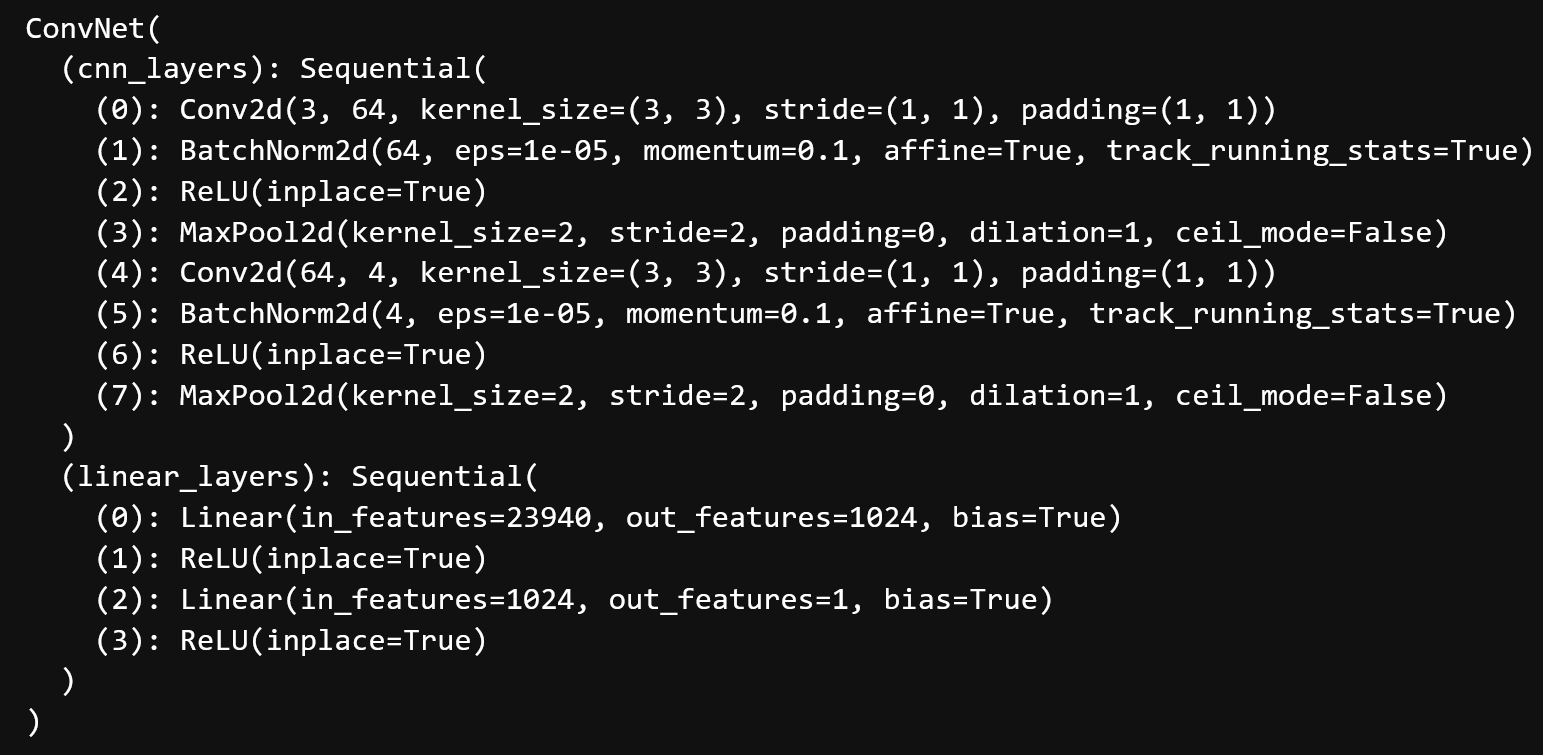

In [32]:
# Your code here
max_iter=10
model = ConvNet()
optimizer=torch.optim.SGD(model.parameters(), lr=0.001)
criterion = torch.nn.MSELoss()


c. Train the model using the dataset above for 10 epochs, and calculate the test set data (read [this](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html) to learn to apply the model after it is trained). Plot the train and test losses.

**Written answer: What can you say about the model? Is it able to predict the prices? How does it compare with the structured data model? Discuss your results.**  [10 pts]

**Hint: If you run out of memory while training, reduce the batch size and restart the notebook kernel running only starting from Task 3**

In [33]:
# Train! [5 pts]
numbindex=[]
loss_list=[]
test_list=[]
for i in range(max_iter):
    epoch_loss=0
    test_loss=0
    for index,(data, label) in enumerate(train_loader):
        optimizer.zero_grad()
        y_pred = model(data)
        loss = criterion(input=y_pred.float(), target=label.reshape(-1,1).float())
        loss.backward()
        optimizer.step()
        epoch_loss+=loss.item()
    
    for index,(data, label) in enumerate(val_loader):
        y_pred=model.forward(data)
        loss = criterion(input=y_pred.float(), target=label.reshape(-1,1).float())
        test_loss+=loss.item()

# Plot the losses [2 pts]
    with torch.no_grad():
        numbindex.append(i)
        loss_list.append(epoch_loss/24)
        test_list.append(test_loss/10)
        print(loss_list)
        print(test_list)



[1.1446683034300804]
[0.6139105811715126]
[1.1446683034300804, 1.1618640013039112]
[0.6139105811715126, 0.6136203333735466]
[1.1446683034300804, 1.1618640013039112, 1.130907230079174]
[0.6139105811715126, 0.6136203333735466, 0.6141123965382576]
[1.1446683034300804, 1.1618640013039112, 1.130907230079174, 1.1400305268665154]
[0.6139105811715126, 0.6136203333735466, 0.6141123965382576, 0.6139105811715126]
[1.1446683034300804, 1.1618640013039112, 1.130907230079174, 1.1400305268665154, 1.0809804126620293]
[0.6139105811715126, 0.6136203333735466, 0.6141123965382576, 0.6139105811715126, 0.6596745759248733]
[1.1446683034300804, 1.1618640013039112, 1.130907230079174, 1.1400305268665154, 1.0809804126620293, 0.9076797539989153]
[0.6139105811715126, 0.6136203333735466, 0.6141123965382576, 0.6139105811715126, 0.6596745759248733, 0.5854376494884491]
[1.1446683034300804, 1.1618640013039112, 1.130907230079174, 1.1400305268665154, 1.0809804126620293, 0.9076797539989153, 0.8247924670577049]
[0.613910581

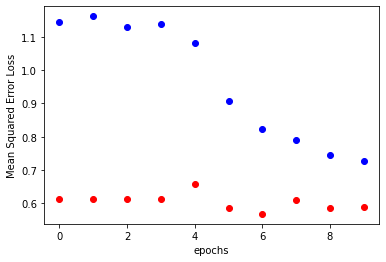

In [34]:
plt.scatter(numbindex,loss_list,c="blue")
plt.scatter(numbindex,test_list,c="red")
plt.xlabel("epochs") 
plt.ylabel("Mean Squared Error Loss") 
plt.show() 

**Written answer: [3 pts]** 
The model might need more training (more epochs), because the training error is still quite high after running 10 epochs. In addition, the test error does not change a lot when we are training the model. The MSE of test set and training set are both larger than 0.5, so the model is not very good at predicting house prices. Because the MSE of test set and training set are larger than the structured data model, our ConvNet model performs worse than the structured data model. However, structured data model were trained for 200 epochs. If we train the ConvNet model for 200 epochs, the performance of the ConvNet model might improve.